In [1]:
import sqlite3
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
# from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler
from sklearn.impute import SimpleImputer
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create your connection.
cnx = sqlite3.connect('database.sqlite')
# cnx
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [3]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


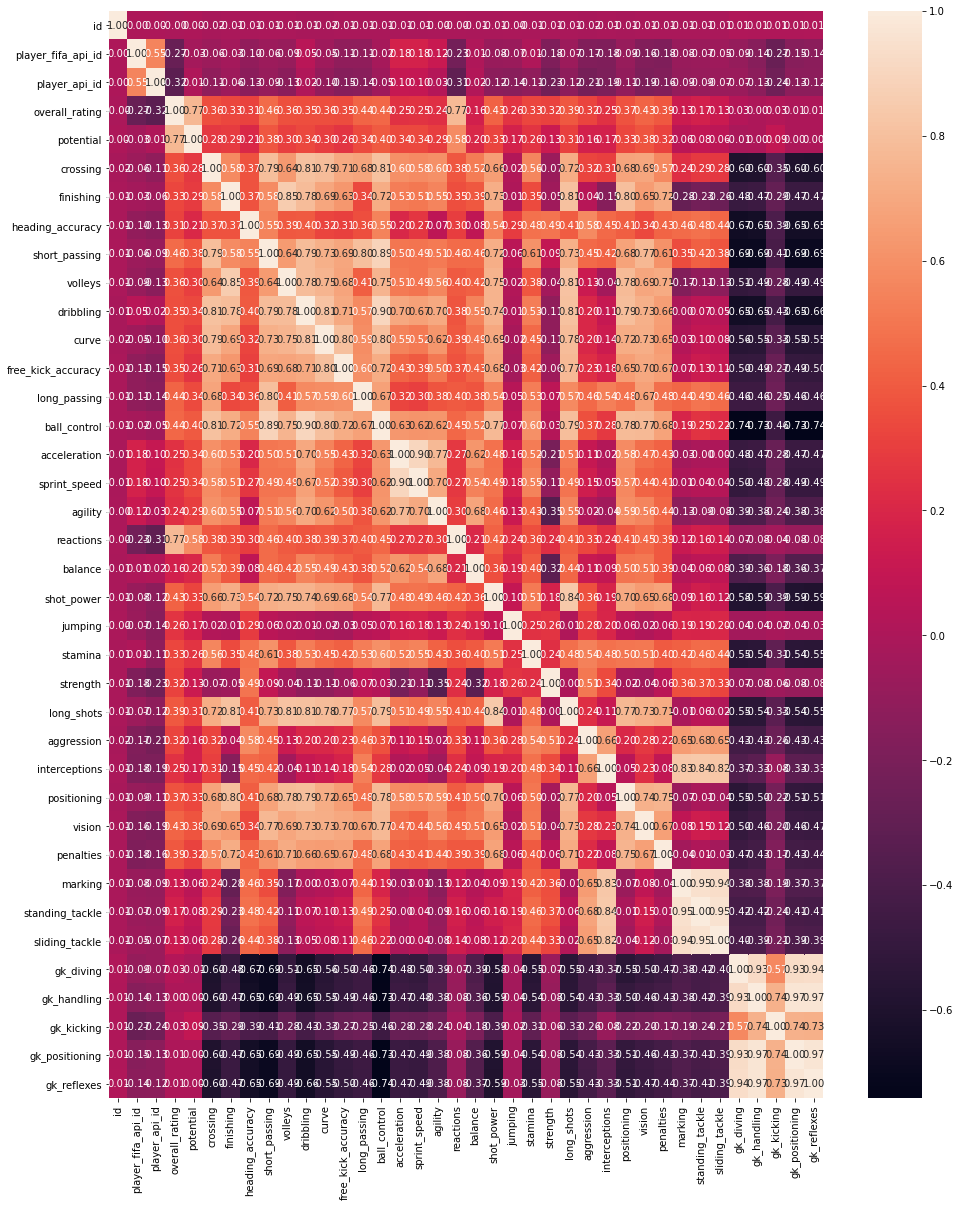

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(16,20))
sns.heatmap(df.corr(),annot=True,fmt='.2f')
# plt.show()

In [6]:
import numpy as np
df_corr=df.corr().abs()
up_tri=df_corr.where(np.triu(np.ones(df_corr.shape[1]),k=1).astype(np.bool))
corr_fea=[column for column in up_tri.columns if any (up_tri[column]>.75)]
print(corr_fea)

['potential', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'sprint_speed', 'agility', 'reactions', 'shot_power', 'long_shots', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_handling', 'gk_positioning', 'gk_reflexes']


In [7]:
df_no_corr=df.drop(corr_fea,axis=1)

In [8]:
df_no_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   preferred_foot       183142 non-null  object 
 6   attacking_work_rate  180748 non-null  object 
 7   defensive_work_rate  183142 non-null  object 
 8   crossing             183142 non-null  float64
 9   finishing            183142 non-null  float64
 10  heading_accuracy     183142 non-null  float64
 11  acceleration         183142 non-null  float64
 12  balance              181265 non-null  float64
 13  jumping              181265 non-null  float64
 14  stamina              183142 non-null  float64
 15  strength         

we can see id, date column cant play any role for analysis so we are removing it 

In [9]:
df_no_corr.drop(["id","date"],axis=1,inplace=True)

In [10]:
df_no_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_fifa_api_id   183978 non-null  int64  
 1   player_api_id        183978 non-null  int64  
 2   overall_rating       183142 non-null  float64
 3   preferred_foot       183142 non-null  object 
 4   attacking_work_rate  180748 non-null  object 
 5   defensive_work_rate  183142 non-null  object 
 6   crossing             183142 non-null  float64
 7   finishing            183142 non-null  float64
 8   heading_accuracy     183142 non-null  float64
 9   acceleration         183142 non-null  float64
 10  balance              181265 non-null  float64
 11  jumping              181265 non-null  float64
 12  stamina              183142 non-null  float64
 13  strength             183142 non-null  float64
 14  aggression           183142 non-null  float64
 15  interceptions    

In [11]:
X=df_no_corr.drop(["overall_rating"],axis=1)
y=df["overall_rating"]

In [12]:
y.isnull().sum()

836

C:\Users\poona\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\poona\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

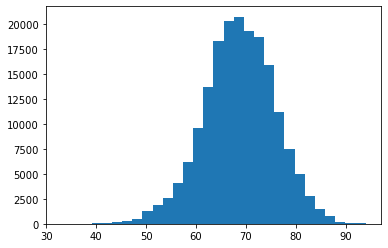

In [13]:
plt.hist(y,30)


almost normal distribution so we can impute mean value for missing value in target.

In [14]:
y=y.fillna(y.mean())

In [15]:
y.isnull().sum()

0

In [16]:
for col in X.columns:
    unique_no=len(X[col].unique())
    print("{col}--- {unique_no}---{typ} ".format(col=col,unique_no=unique_no,typ=X[col].dtype))

player_fifa_api_id--- 11062---int64 
player_api_id--- 11060---int64 
preferred_foot--- 3---object 
attacking_work_rate--- 9---object 
defensive_work_rate--- 20---object 
crossing--- 96---float64 
finishing--- 98---float64 
heading_accuracy--- 97---float64 
acceleration--- 87---float64 
balance--- 82---float64 
jumping--- 80---float64 
stamina--- 85---float64 
strength--- 83---float64 
aggression--- 92---float64 
interceptions--- 97---float64 
gk_diving--- 94---float64 
gk_kicking--- 98---float64 


we can see there are three object column,so we will use one hot encoding for them

In [17]:
X_new=pd.get_dummies(X,columns=['preferred_foot','attacking_work_rate','defensive_work_rate'],drop_first=True)

In [18]:
import numpy as np
imp_mean=SimpleImputer(np.nan,strategy='mean')
X_new=imp_mean.fit_transform(X_new)

C:\Users\poona\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass missing_values=nan as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [19]:
np.isnan(X_new)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y,test_size=.30,random_state=0)


In [21]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(),             #preprocessing(standard scalling)
                     LinearRegression())           #estimator(linear regression)

cv = ShuffleSplit(random_state=0)   #defining type of cross_validation(shuffle spliting)

param_grid = {'linearregression__n_jobs': [-1]}     #parameters for model tunning

grid_lin = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [22]:
grid_lin.fit(X_train, y_train) 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__n_jobs': [-1]})

In [23]:
grid_lin.best_params_

{'linearregression__n_jobs': -1}

In [24]:
pipe = make_pipeline(StandardScaler(),                  #preprocessing
                     DecisionTreeRegressor(criterion='mse', random_state=0))          #estimator

cv = ShuffleSplit(n_splits=10, random_state=42)        #cross validation

param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]}

grid_dec = GridSearchCV(pipe, param_grid=param_grid, cv=cv)


In [25]:
grid_dec.fit(X_train, y_train)          #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=0))]),
             param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]})

In [26]:
grid_dec.best_params_

{'decisiontreeregressor__max_depth': 13}

In [27]:
pipe = make_pipeline(StandardScaler(),
                     RandomForestRegressor(n_estimators=100, random_state=123))

cv = ShuffleSplit(test_size=0.2, random_state=0)

param_grid = {'randomforestregressor__max_features':['sqrt', 'log2', 10],
              'randomforestregressor__max_depth':[9, 11, 13]}                 

grid_rand = GridSearchCV(pipe, param_grid=param_grid, cv=cv)    

In [28]:
grid_rand.fit(X_train, y_train)          #training


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=123))]),
             param_grid={'randomforestregressor__max_depth': [9, 11, 13],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 10]})

In [29]:
grid_rand.best_params_

{'randomforestregressor__max_depth': 13,
 'randomforestregressor__max_features': 10}

In [30]:
pipe = make_pipeline(StandardScaler(),
                     GradientBoostingRegressor(n_estimators= 100, random_state=42))

cv = ShuffleSplit(n_splits=10, random_state=0)

param_grid = {'gradientboostingregressor__max_depth': [5, 7],
              'gradientboostingregressor__learning_rate': [0.1, 0.3]}

grid_xgb= GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs= -1)

In [31]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__learning_rate': [0.1, 0.3],
                         'gradientboostingregressor__max_depth': [5, 7]})

In [32]:
grid_xgb.best_params_

{'gradientboostingregressor__learning_rate': 0.3,
 'gradientboostingregressor__max_depth': 7}

In [33]:
print("""Linear Regressor accuracy is {lin}
DecisionTree Regressor accuracy is {Dec}
RandomForest regressor accuracy is {ran}
XGBoost regressor accuracy is {xgb}""".format(lin=grid_lin.score(X_test, y_test),
                                                       Dec=grid_dec.score(X_test, y_test),
                                                       ran=grid_rand.score(X_test, y_test),
                                                       xgb=grid_xgb.score(X_test, y_test)))

Linear Regressor accuracy is 0.5944378243945203
DecisionTree Regressor accuracy is 0.8536861050202109
RandomForest regressor accuracy is 0.8902241349568333
XGBoost regressor accuracy is 0.9161961157115521


XGBoost Regressor would be opted bcz it has highest accuracy